In [32]:
import polars as pl
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# from lonboard import Map, ScatterplotLayer, PolygonLayer
from upsetplot import plot
from matplotlib import pyplot

# Read in the data

In [24]:


# Read CSV file
dfpl = pl.read_csv("../data/survey.csv", null_values=["NULL", "null"])


# Prep the data

- pull in GIS
- create assessed column 
- create arrivals, departures and returnee columns (scrapboox 6)
- pull in SMOD and do urban/rural

In [25]:
# create arrivals departures and returnees columns
dfpl = dfpl.with_columns([
    pl.lit("no").alias("arrivals"),
    pl.lit("no").alias("departures"),
    pl.lit("no").alias("returnees")
]).with_columns([
    # Set movement types to 'yes' based on number presence
    pl.when(pl.col("m1536_loc_num_arrival_ind_period") > 0)
      .then(pl.lit("yes"))
      .otherwise(pl.col("arrivals"))
      .alias('arrivals'),
    pl.when(pl.col("m1540_loc_num_depart_ind_period") > 0)
      .then(pl.lit("yes"))
      .otherwise(pl.col("departures"))
      .alias('departures'),
    pl.when(pl.col("m0851_loc_num_return_idp_ind") > 0)
      .then(pl.lit("yes"))
      .otherwise(pl.col("returnees"))
      .alias('returnees')
])

In [26]:
df = dfpl.to_pandas()

In [12]:
# Create geometry points from latitude and longitude coordinates
geometry = [Point(xy) for xy in zip(df['_m1650_loc_gps_coords_longitude'], df['_m1650_loc_gps_coords_latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [14]:
gdf_clean = gdf.dropna(subset=['_m1650_loc_gps_coords_latitude'])
gdf_clean = gdf_clean.to_crs(epsg=4326)

In [ ]:
admin2 = gpd.read_file("../data/mwi_adm2.geojson")
admin2 = admin2.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)
joined = gpd.sjoin(admin2, gdf, how="inner")

In [ ]:
admin3 = gpd.read_file("../data/mwi_adm3.geojson")
admin3 = admin3.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)
joined2 = gpd.sjoin(admin3, gdf, how="inner")

# Analysis

## Coverage

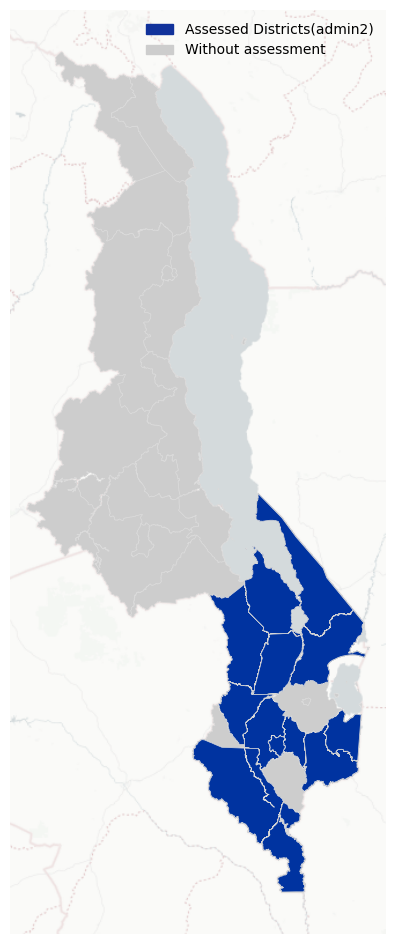

In [ ]:


fig, ax = plt.subplots(figsize=(12, 12))

admin2.plot(ax=ax, color='#cdcdcd', edgecolor='#dadada',  linewidth=0.5)
joined.plot(ax=ax, color='#0033A0', alpha=1, edgecolor='#dadada',  linewidth=0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels,  attribution=False)

assessed_patch = mpatches.Patch(color='#11329B', label='Assessed Districts(admin2)')
missing_patch = mpatches.Patch(color='#cdcdcd', label='Without assessment')
ax.legend(handles=[assessed_patch, missing_patch], loc='upper right', frameon=False)
ax.set_axis_off()
plt.savefig(f'../figures/fig-map-static-coverage-adm2.png', format='png', bbox_inches='tight', dpi=300)


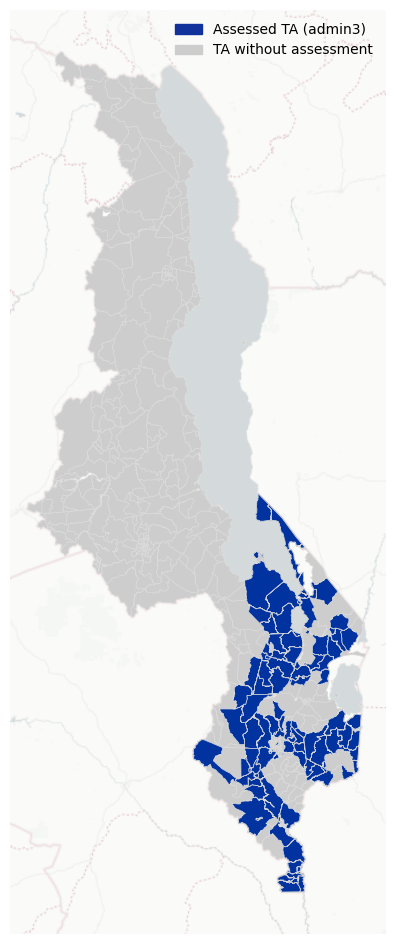

In [ ]:

fig, ax = plt.subplots(figsize=(12, 12))

admin3.plot(ax=ax, color='#cdcdcd', edgecolor='#dadada', linewidth=0.5)
joined2.plot(ax=ax, color='#0033A0', alpha=1, edgecolor='#dadada', linewidth=0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels,  attribution=False)

assessed_patch = mpatches.Patch(color='#11329B', label='Assessed TA (admin3)')
missing_patch = mpatches.Patch(color='#cdcdcd', label='TA without assessment')
ax.legend(handles=[assessed_patch, missing_patch], loc='upper right', frameon=False)
ax.set_axis_off()
plt.savefig(f'../figures/fig-map-static-coverage-adm3.png', format='png', bbox_inches='tight', dpi=300)


In [ ]:
# df_clean = gdf.dropna(subset=['_m1650_loc_gps_coords_latitude'])
# df_clean = df_clean.to_crs(epsg=4326)

# layer = ScatterplotLayer.from_geopandas(
#     df_clean,
#     get_fill_color=[19, 38, 147],
#     radius_min_pixels=5,  
#     stroked=True,
#     get_line_color=[0, 0, 0],
#     auto_highlight=True,
# )
# m = Map(layer)
# m.to_html("../figures/fig-map-interactive-coverage-locations.html")
# m


Map(custom_attribution='', layers=(ScatterplotLayer(auto_highlight=True, get_fill_color=[19, 38, 147], get_lin…

In [ ]:

# assessed = PolygonLayer.from_geopandas(
#     joined.to_crs(epsg=4326),
#     get_line_width=20,  # width in default units (meters)
#     line_width_min_pixels=1,  # minimum width when zoomed out
#     get_fill_color=[19, 38, 147],  # light blue
#     get_line_color=[218,218,218],  # dark border color
# )
# admin_units = PolygonLayer.from_geopandas(
#     admin3.to_crs(epsg=4326),
#     get_line_width=20,  # width in default units (meters)
#     line_width_min_pixels = 1,
#     get_fill_color=[205,205,205	],  # light blue
#     get_line_color=[218,218,218],  # dark border color
    
# )
# m = Map([admin_units, assessed])
# m.to_html("../figures/fig-map-interactive-coverage-adm3.html")
# m

Map(custom_attribution='', layers=(PolygonLayer(get_fill_color=[205, 205, 205], get_line_color=[218, 218, 218]…

In [ ]:


test = df_clean.explore(tiles="CartoDB.PositronNoLabels", tooltip=['m0448_loc_site_name'],color='#11329B', attr='')
test.save("../figures/fig-map-interactive-coverage-adm3.html")
test

## Movement Type

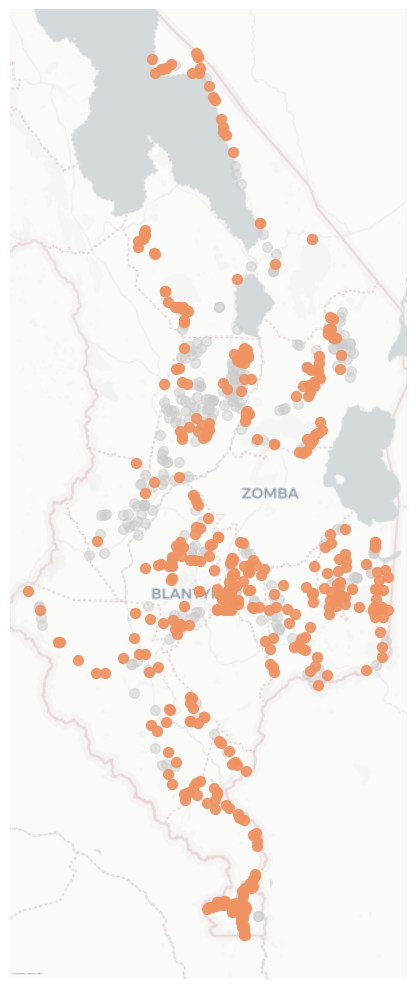

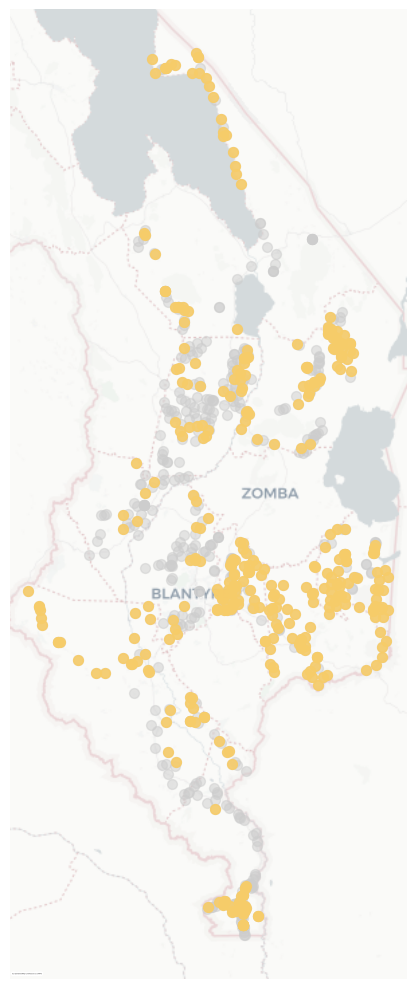

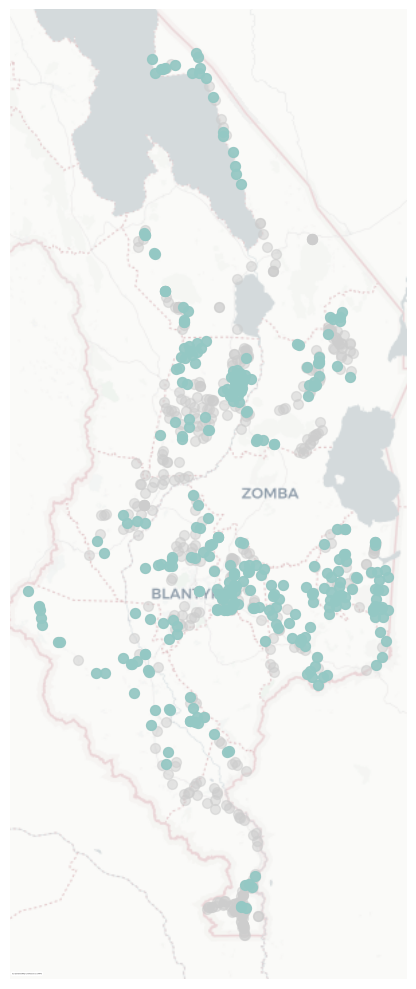

In [22]:
def create_movement_map(movement_type, color, title, filename):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot locations with movement type
    locations = gdf[gdf[movement_type] == "yes"]
    gdf_clean.to_crs(epsg=3857).plot(ax=ax, color='#cdcdcd', edgecolor='#cdcdcd', markersize=50, alpha=0.5)
    locations.to_crs(epsg=3857).plot(ax=ax, color=color, alpha=0.9, markersize=50)
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=None, attribution_size=0)
    
    # Customize plot
    ax.set_axis_off()
    ax.set_aspect('equal')
    # ax.legend([title], loc='upper right')
    
    # Save and close
    plt.tight_layout()
    plt.savefig(f'../figures/{filename}.svg', format='svg', bbox_inches='tight', dpi=300)
   
    plt.show()
    plt.close()

# Create three separate maps
create_movement_map('arrivals', '#F09362', 'Locations with Arrivals', 'fig-map-locations-arrivals')
create_movement_map('departures', '#F7CC69', 'Locations with Departures', 'fig-map-locations-departures')
create_movement_map('returnees', '#94C8C4', 'Returns', 'fig-map-locations-returns')

In [30]:
count_yes_arrivals = len(dfpl.filter(pl.col("arrivals") == "yes"))
count_yes_departures = len(dfpl.filter(pl.col("departures") == "yes"))
count_yes_returnees = len(dfpl.filter(pl.col("returnees") == "yes"))
print("Arrivals: ",count_yes_arrivals)
print("Departures: ",count_yes_departures)
print("Returns: ",count_yes_returnees)

Arrivals:  444
Departures:  388
Returns:  313


In [31]:
df_temp = df[['arrivals',
 'departures',
 'returnees']]

# Create binary indicators for each movement type
movement_types = ['arrivals', 'departures', 'returnees']
df_indicators = df_temp.copy()

# Convert yes/no to boolean True/False
for col in movement_types:
    df_indicators[col] = df_indicators[col] == 'yes'

# Create a list of tuples for all combinations
combinations = df_indicators.groupby(movement_types).size()

print("Movement type combinations and their frequencies:")
print(combinations)

Movement type combinations and their frequencies:
arrivals  departures  returnees
False     False       False        150
                      True          51
          True        False         71
                      True          60
True      False       False        139
                      True          48
          True        False        103
                      True         154
dtype: int64


/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/brian/Code/malawi/.pixi/envs/default/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

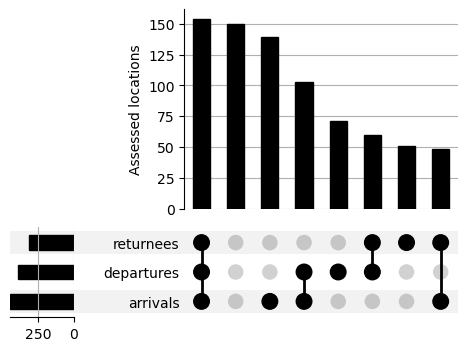

In [33]:

# Create and customize the upset plot
plot(combinations, sort_by='cardinality')

# Customize the plot
#plt.title('Assessed locations with population types')
plt.ylabel('Assessed locations')


# Show the plot


# Save the plot
plt.savefig('../figures/fig-upset-movement-types-temp.svg', format='svg', bbox_inches='tight', dpi=300)
pyplot.show()
plt.close()

/var/folders/q2/r6cyvbjx443d2txp6kr8tl_h0000gn/T/ipykernel_91970/1002233514.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  counts = dfpl.group_by('m0342_loc_site_type_multiple').agg(pl.count()).sort('count', descending=True)


NameError: name 'hbar' is not defined

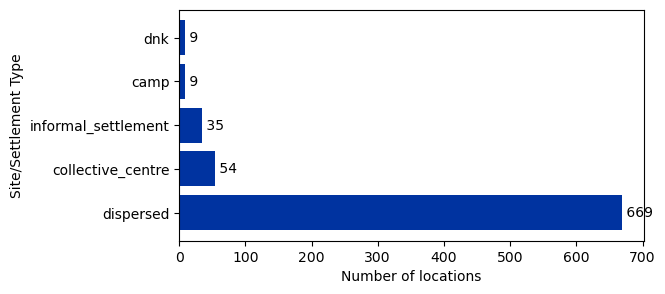

In [67]:
import polars as pl
import matplotlib.pyplot as plt

# Get value counts from the column
counts = dfpl.group_by('m0342_loc_site_type_multiple').agg(pl.count()).sort('count', descending=True)
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(6, 3))

# Create horizontal bar chart
ax.barh(y=counts['m0342_loc_site_type_multiple'], 
        width=counts['count'],
        color='#0033A0')

# Customize the chart
#ax.set_title('Distribution of Location Site Types', pad=15)
ax.set_xlabel('Number of locations')
ax.set_ylabel('Site/Settlement Type')

# Add value labels on the bars
for i, v in enumerate(counts['count']):
    ax.text(v, i, f' {v}', va='center')

fig-hbar-loc-settlement-type
plt.tight_layout()

# Display the plot
plt.savefig(f'../figures/fig-hbar-location-site-types.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

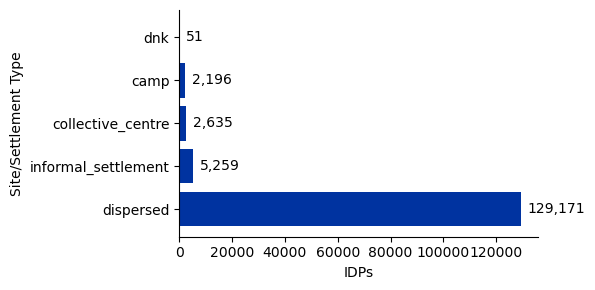

In [63]:
import polars as pl
import matplotlib.pyplot as plt

# Get value counts from the column
counts = dfpl.group_by('m0342_loc_site_type_multiple').agg(pl.sum('m0310_loc_num_idp_ind')).sort('m0310_loc_num_idp_ind', descending=True)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(6, 3))

# Create horizontal bar chart
bars = ax.barh(y=counts['m0342_loc_site_type_multiple'], 
        width=counts['m0310_loc_num_idp_ind'],
        color='#0033A0')

# Customize the chart
#ax.set_title('Distribution of Location Site Types', pad=15)
ax.set_xlabel('IDPs')
ax.set_ylabel('Site/Settlement Type')

# Add value labels on the bars
# for i, v in enumerate(counts['m0310_loc_num_idp_ind']):
#     ax.text(v, i, f' {v}', va='center')
ax.bar_label(bars, padding=5, fmt='{:,.0f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.savefig(f'../figures/fig-hbar-population-site-types.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()